<script>
var css = '.container { width: 100% !important; padding-left: 1em; padding-right: 2em; } div.output_stderr { background: #FFA; }',
    head = document.head || document.getElementsByTagName('head')[0],
    style = document.createElement('style');

style.type = 'text/css';
if (style.styleSheet){
  style.styleSheet.cssText = css;
} else {
  style.appendChild(document.createTextNode(css));
}

head.appendChild(style);
</script>

In [1]:
# %load nbheader.py
%reload_ext autoreload
%autoreload 2
from typing import List, Tuple, Dict, Any, Union
import sys
import os
import re
import json
import datetime
import numpy as np
import pandas as pd
settings = {
    'max_columns': 50,
    'max_colwidth': 100,
    'max_rows': 200,
    'precision': 3,
    }
for option, value in settings.items():
    pd.set_option("display.{}".format(option), value)
import matplotlib.pyplot as plt



# Decision Tree
Let's see how well a decision tree can classify the data. Hereby we need to consider
1. the parameters to the classifier, and
2. the features of the data set that will be used.
We may just explore the impact of the maximum depth of the decision tree. Two of the 16 features ('day' and 'month') may not be useful because they reflect a date, and we're not looking for seasonal effects. So, it's fairly safe to take them out.

Once the dataset is loaded we will convert the categorical data into numeric values.

Finding the right parameters and features for the best performing classifier can be a challenge. The number of possible configurations grows quickly, and knowing how they perform requires training and testing with each of them.

We may also run the training and testing on a configuration multiple times with different random splits of the data set. The performance metrics will be avaraged over the iterations.

We use percision, recall, and the F1 score to evaluate each configuration.


In [2]:
### Load Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree
# import pydot_ng as pdot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
import itertools

## Reading Data

https://archive.ics.uci.edu/dataset/222/bank+marketing

https://www.semanticscholar.org/paper/A-data-driven-approach-to-predict-the-success-of-Moro-Cortez/cab86052882d126d43f72108c6cb41b295cc8a9e

https://repositorio.iscte-iul.pt/bitstream/10071/9499/5/dss_v3.pdf


Data https://archive.ics.uci.edu/static/public/222/bank+marketing.zip


In [3]:
# %%sh
# mkdir -p data
# cd data
# wget "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"
# unzip -l "bank+marketing.zip"


In [4]:
# %%sh
# cd data
# if [ ! -f "bank.zip" ]
# then
#     unzip "bank+marketing.zip"
# else
#     unzip bank.zip
#     unzip bank-additional.zip
# fi


In [5]:
# ! unzip data
# ! unzip data/bank-additional.zip

In [6]:
# ! ls -l /data/archive.ics.uci.edu/BankMarketing

In [8]:
### Read data
DATAFILE = '/data/archive.ics.uci.edu/BankMarketing/bank.csv'
#DATAFILE = 'data/bank.csv'
df = pd.read_csv(DATAFILE, sep=';')

In [9]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,4521.0,NaN,NaN,NaN,41.17,10.576,19.0,33.0,39.0,49.0,87.0
job,4521,12,management,969,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,4521,3,married,2797,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,4521,4,secondary,2306,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,4521,2,no,4445,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,4521.0,NaN,NaN,NaN,1422.658,3009.638,-3313.0,69.0,444.0,1480.0,71188.0
housing,4521,2,yes,2559,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,4521,2,no,3830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,4521,3,cellular,2896,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,4521.0,NaN,NaN,NaN,15.915,8.248,1.0,9.0,16.0,21.0,31.0


In [10]:
### use sets and '-' difference operation 'A-B'. Also there is a symmetric different '^'
all_features = set(df.columns)-set(['y'])
num_features = set(df.describe().columns)
cat_features = all_features-num_features
print("All features:         ", ", ".join(all_features), "\nNumerical features:   ", ", ".join(num_features), "\nCategorical features: ", ", ".join(cat_features))

All features:          contact, age, duration, poutcome, previous, education, loan, campaign, pdays, housing, default, job, balance, day, marital, month 
Numerical features:    age, duration, pdays, balance, day, previous, campaign 
Categorical features:  contact, housing, default, job, poutcome, marital, month, education, loan


In [11]:
### convert to categorical variables to numeric ones
level_substitution = {}

def levels2index(levels):
    dct = {}
    for i in range(len(levels)):
        dct[levels[i]] = i
    return dct

df_num = df.copy()

for c in cat_features:
    level_substitution[c] = levels2index(df[c].unique())
    df_num[c].replace(level_substitution[c], inplace=True)

## same for target
df_num.y.replace({'no':0, 'yes':1}, inplace=True)
display(df_num.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,0,0,0,0,1787,0,0,0,19,0,79,1,-1,0,0,0
1,33,1,0,1,0,4789,1,1,0,11,1,220,1,339,4,1,0
2,35,2,1,2,0,1350,1,0,0,16,2,185,1,330,1,1,0
3,30,2,0,2,0,1476,1,1,1,3,3,199,4,-1,0,0,0
4,59,3,0,1,0,0,1,0,1,5,1,226,1,-1,0,0,0


In [12]:
### create feature matrix and target vector
# X = df_num[list(all_features-set(['day', 'month']))].as_matrix()
X = df_num[list(all_features-set(['day', 'month']))].values
# y = df_num.y.as_matrix()
y = df_num.y.values
X, y

(array([[   0,   30,   79, ...,    0, 1787,    0],
        [   0,   33,  220, ...,    1, 4789,    0],
        [   0,   35,  185, ...,    2, 1350,    1],
        ...,
        [   0,   57,  151, ...,    5,  295,    0],
        [   0,   28,  129, ...,    3, 1137,    0],
        [   0,   44,  345, ...,    6, 1136,    1]]),
 array([0, 0, 0, ..., 0, 0, 0]))

## Evaluation
Test how Maximum Depth of tree impacts performance

In [13]:
for d in [3, 5, 7, 11, 13]:
    clf = DecisionTreeClassifier(max_depth=d)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
    clf.fit(X_train, y_train)
    ŷ = clf.predict(X_test)
    print('Depth %d' % d)
    print(classification_report(y_test, ŷ))

Depth 3
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1620
           1       0.55      0.35      0.43       189

    accuracy                           0.90      1809
   macro avg       0.74      0.66      0.69      1809
weighted avg       0.89      0.90      0.89      1809

Depth 5
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1620
           1       0.52      0.35      0.42       189

    accuracy                           0.90      1809
   macro avg       0.72      0.66      0.68      1809
weighted avg       0.88      0.90      0.89      1809

Depth 7
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1620
           1       0.50      0.33      0.40       189

    accuracy                           0.90      1809
   macro avg       0.71      0.65      0.67      1809
weighted avg       0.88      0.90      0.89      1

Two methods from `sklearn.metrics` can be helpful:
1. `confusion_matrix` produces a confusion matrix
2. `precision_recall_fscore_support` returns a matrix with values for each of them across all target levels.

In [14]:
cm = confusion_matrix(y_test, ŷ)
cm

array([[1484,  136],
       [ 114,   75]])

In [15]:
prf1s = precision_recall_fscore_support(y_test, ŷ)
prf1s

(array([0.92866083, 0.35545024]),
 array([0.91604938, 0.3968254 ]),
 array([0.922312, 0.375   ]),
 array([1620,  189]))

In [ ]:
perf = None
for i in range(100):
    if type(perf)!=type(None):
        perf = np.vstack((perf, np.array(prf1s).reshape(1,8)))
    else:
        perf = np.array(prf1s).reshape(1,8)
perf_agg = perf.mean(axis=0)
pd.DataFrame(perf_agg.reshape(1,8), columns=[[b for a in ['Precision', 'Recall', 'F1_score', 'Support'] for b in [a, a]], ['no', 'yes']*4])
##pd.DataFrame([5,5, 'a|b|c'] + list(perf.mean(axis=0)), columns=perf_df.columns)

In [16]:
performance_df = pd.DataFrame(columns=[
        ['Params']*3 + [b for a in ['Precision', 'Recall', 'F1_score', 'Support'] for b in [a, a]],
        ['MaxDepth', 'Nfeature', 'Features'] + ['no', 'yes']*4
    ])
tempdf = pd.concat([
        pd.DataFrame({'a': [1], 'b': [2], 'c': ['Hello']}),
        pd.DataFrame(np.zeros((1,8)))
    ], axis=1, ignore_index=True)

tempdf.columns=performance_df.columns
#performance_df
tempdf

Params                   Precision      Recall      F1_score      Support  \
  MaxDepth Nfeature Features        no  yes     no  yes       no  yes      no   
0        1        2    Hello       0.0  0.0    0.0  0.0      0.0  0.0     0.0   

        
   yes  
0  0.0

In [17]:
pd.DataFrame(np.zeros(8).reshape(1,8))

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
import shap

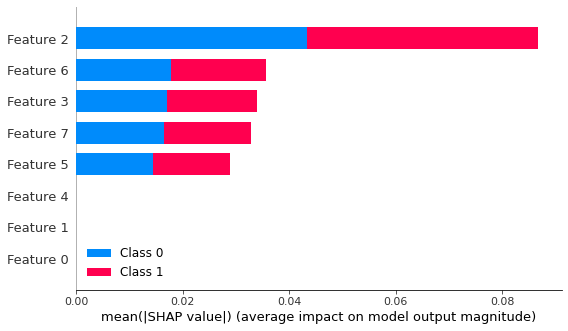

In [26]:
fig = plt.figure(figsize=(15,8))
shap_values = shap.TreeExplainer(clf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
fig.savefig('shap-example.png')

## The Heavy Lifting
Now, let's run the performance evaluation across a number of configurations. We'll collect the results for each configuration into a dataframe.

In [21]:
# creating a template (i.e. empty table)
performance_template_df = pd.DataFrame(columns= [
        ['Params']*3 + [b for a in ['Precision', 'Recall', 'F1_score', 'Support'] for b in [a, a]],
        ['MaxDepth', 'Nfeature', 'Features'] + ['no', 'yes']*4
    ])
performance_template_df

Empty DataFrame
Columns: [(Params, MaxDepth), (Params, Nfeature), (Params, Features), (Precision, no), (Precision, yes), (Recall, no), (Recall, yes), (F1_score, no), (F1_score, yes), (Support, no), (Support, yes)]
Index: []

The following code implements nested loops for MaxDepth, number and permutation of features. In addition, we have an internal loop to
aggregate the performance metrics over a number of different random splits.

The outer two loops, however, only iterate over one value each. The commmented code shows how they should run...

In [25]:
## %%time
perf_arr = None
best_clf = None
best_perf_df = None
performance_df = performance_template_df.copy() #-- always start fresh
j = 0
for MaxDepth in [5]: ###range(5,9):
    for Nftr in [8]: ###[len(all_features) - k for k in range(len(all_features)-2))]:
        for ftrs in itertools.combinations(all_features-set(['day', 'month']), Nftr):
            # X = df_num[list(ftrs)].as_matrix()
            X = df_num[list(ftrs)].values
            clf = DecisionTreeClassifier(max_depth=MaxDepth)

            perf_arr = None    #-- this array will hold results for different random samples
            for i in range(3): ### running train and test on different random samples
                j += 1 
                # print(f"Experiment #{j:2d}: MaxDepth={MaxDepth}, NumFeatures={Nftr}")
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=i)
                clf.fit(X_train, y_train)
                ŷ = clf.predict(X_test)
                #Prec, Recall, F1, Supp 
                prf1s = precision_recall_fscore_support(y_test, ŷ, zero_division=np.nan)

                ## 
                if type(perf_arr)!=type(None):
                    perf_arr = np.vstack((perf_arr, np.array(prf1s).reshape(1,8)))
                else:
                    perf_arr = np.array(prf1s).reshape(1,8)
            perf_agg = perf_arr.mean(axis=0)  #-- mean over rows, for each column
            perf_df = pd.concat([    #-- creating a 1 row dataframe is a bit tricky because of the different data types
                        pd.DataFrame({'a': [MaxDepth], 'b': [Nftr], 'c': ['|'.join(list(ftrs))]}),
                        pd.DataFrame(perf_agg.reshape(1, 8))
                    ], axis=1, ignore_index=True)
            perf_df.columns=performance_df.columns
            if best_clf is None:
                best_clf = clf
                best_perf_df = perf_df
            elif perf_df.F1_score.yes.values[0] > best_perf_df.F1_score.yes.values[0]:
                best_clf = clf
                best_perf_df = perf_df
                
            performance_df = pd.concat([performance_df, perf_df], ignore_index=True)
            
print(f"Number of experiments: {performance_df.shape[0]:,}")

Number of experiments: 3,003


In [ ]:
perf_df.F1_score.yes.values[0]

In [27]:
performance_df.shape

(3003, 11)

That took a while (about 2 minutes). Once computations take that long we should look at a different way to implement them ... ** outside the notebook **.

In [28]:
performance_df.head()

Params           \
  MaxDepth Nfeature   
0        5        8   
1        5        8   
2        5        8   
3        5        8   
4        5        8   

                                                                  Precision  \
                                                         Features        no   
0  contact|age|duration|poutcome|previous|education|loan|campaign     0.920   
1     contact|age|duration|poutcome|previous|education|loan|pdays     0.917   
2   contact|age|duration|poutcome|previous|education|loan|housing     0.919   
3   contact|age|duration|poutcome|previous|education|loan|default     0.919   
4       contact|age|duration|poutcome|previous|education|loan|job     0.922   

         Recall        F1_score        Support         
     yes     no    yes       no    yes      no    yes  
0  0.546  0.960  0.369    0.940  0.439   799.0  106.0  
1  0.578  0.967  0.338    0.941  0.426   799.0  106.0  
2  0.546  0.962  0.355    0.940  0.429   799.0  106.0  
3  0.548  0.961  0.361    0.940  0.434   799.0  106.0  
4  0.549  0.958  0.386    0.940  0.451   799.0  106.0

Let's see what the best performing configuration with respect to the F1-score of 'yes' is:

In [ ]:
best = performance_df.F1_score.yes.argmax()
print(performance_df.iloc[best])
print("\nFeatures: ", ', '.join([ '"%s"'%f for f in performance_df.iloc[best].Params.Features.split('|') ], ))

In [ ]:
# import pydot_ng
from sklearn import tree

In [ ]:
plt.figure(figsize=(20, 20))
tree.plot_tree(best_clf, filled=True);
plt.savefig("bank_decision_tree.pdf")